# Загрузка данных

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix
import datetime
sns.set(style="whitegrid")

In [2]:
root_path = os.getcwd() # directory of the file
dir_path = os.path.join(root_path, "data") # "root_path/data/" - directory of data files

In [3]:
communications = pd.read_csv(os.path.join(dir_path, 'communications.csv'), sep=';')
communications["communication_dt"] = pd.to_datetime(communications["communication_dt"])
communications["communication_score_bin"] = communications["communication_score"].apply(lambda x: 1 if x > 75 else 0)
communications.head(5)

,communication_id,communication_dt,employee_id,communication_score,util_flg,communication_score_bin
0,177074281189583840,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0,1
1,189925315406757324,2023-07-29,e6384711-4917-13d2-9bc6-3fc5eeb5ba4f,100,0,1
2,321818238739717242,2023-09-06,ab541d87-4c7b-c19a-b776-42849e02b89f,43,1,0
3,192259329962028989,2023-06-19,0a0a0c8a-aa00-ade5-0f74-a3f0ca981ed7,100,1,1
4,705274671052151857,2023-08-11,f93882cb-d8fc-7fb7-94c1-011d63be6fb6,46,0,0


In [4]:
communications.shape

(5345246, 6)

In [5]:
employees = pd.read_csv(os.path.join(dir_path, 'employees.csv'), sep=';')
employees.head(5)

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1
1,ac1dd209-cbcc-5e5d-1c6e-28598e8cbbe8,M,4,32,93db85ed-909c-1383-8ff9-5ccfa94cebd9,654,0,2,1
2,a8c88a00-55f6-36e4-a163-a5e3d16adab7,F,5,34,9a115815-4dfa-42ca-ddbd-0694a4e9bdc8,276,1,2,1
3,c91591a8-d461-c286-9b9f-535ded3e213e,F,4,33,9f61408e-3afb-633e-50cd-f1b20de6f466,50,2,0,1
4,bc731692-9fe1-545b-f0b9-8d114ee3ecb8,M,0,33,a97da629-b098-b75c-294d-ffdc3e463904,274,1,2,1


In [6]:
employees.shape

(2381, 9)

In [7]:
courses_passing = pd.read_csv(os.path.join(dir_path, 'courses_passing.csv'), sep=';')
courses_passing['start_dt'] = pd.to_datetime(courses_passing['start_dt'])
courses_passing['last_activity_dt'] = pd.to_datetime(courses_passing['last_activity_dt'])
courses_passing.head(5)

,course_id,employee_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,24,53ed35c7-4a2e-c275-b837-374f04396c03,1.0,2023-01-30,2023-02-05,2023-02-05 00:00:00,6.0
1,83,202cb962-ac59-075b-964b-07152d234b70,1.0,2023-08-29,2023-09-10,2023-09-10 00:00:00,12.0
2,4,05f971b5-ec19-6b8c-65b7-5d2ef8267331,1.0,2023-07-29,2023-08-09,2023-08-09 00:00:00,11.0
3,79,f4a331b7-a22d-1b23-7565-d8813a34d8ac,1.0,2023-05-30,2023-06-09,2023-06-09 00:00:00,10.0
4,6,aba3b6fd-5d18-6d28-e06f-f97135cade7f,1.0,2023-07-12,2023-07-22,2023-07-22 00:00:00,10.0


In [8]:
courses_passing.shape

(10950, 7)

In [9]:
courses_info = pd.read_csv(os.path.join(dir_path, 'courses_info.csv'), sep=';')
courses_info.head(5)

,course_id,course_nm
0,3,Улучшение качества обслуживания клиентов: Осно...
1,76,Как эффективно использовать психологию в обслу...
2,22,Эффективное обучение клиентов в использовании ...
3,53,Как эффективно реагировать на изменения потреб...
4,7,Построение долгосрочных отношений с клиентами:...


In [10]:
courses_info.shape

(92, 2)

In [11]:
def built_time_series(data_communications, score_column, flag=True):
    '''
    Создание временных рядов score для каждого работника
    input:
    data_communications - communications data
    score_column - колонка, по которой считается скор
    method - метод расчета скора
    
    output:
    grouped_communications - DaraFrame c группировкой по работнику и дате с агрегацией score в среднем
    progresses_communication_score - массив временных рядов score для каждого работника
    dates - массив дат коммуникаций в колл центре для каждого пользователя
    employees_dict - словарь, кодирующий id работника в число
    '''
    
    grouped_communications = data_communications.groupby(['employee_id', 'communication_dt'], as_index=False)[score_column].mean()
    employee_id = ""
    progresses_score = []
    dates = []
    employees_dict = {}
    index = 0
    for i in range(grouped_communications.shape[0]):        
        if grouped_communications.loc[i, 'employee_id'] != employee_id:
            employee_id = grouped_communications.loc[i, 'employee_id']
            employees_dict[employee_id] = index
            index += 1
            progresses_score.append([])
            dates.append([])
            
        progresses_score[-1].append(grouped_communications.loc[i, score_column])
        dates[-1].append(grouped_communications.loc[i, 'communication_dt'])
        
    if flag:   
        return employees_dict, progresses_score, dates
    else:
        return progresses_score

def exp_decay_window(gamma, time_series, date_arr, date_start, date_end, degree=1, bias=0):
    '''
    Расчет разницы score для определнной даты, отвечающий за раздел временного ряда на период до и после.
    Окно работает в две стороны от даты и имеет форму Лапласса.
    input:
    gamma - показатель экспоненты в знаменателе
    time_series - временной ряд одного работника
    date_arr - массив дат коммунникаций одного работника
    date_start - дата начала курса
    date_start - дата окончания курса
    degree - степень экспоненты (1 - затух экс, 2 - гаусс)
    bias - смещение (инерция скора после окончания куса)
    
    output:
    (score_after - score_before) - разница score из-за появления события
    '''
    def binary_search(date_arr, date_check):
        '''
        Обычный бинарный поиск
        '''
        low = 0
        high = len(date_arr) - 1
        while low <= high:
            mid = (low + high) // 2
            guess = date_arr[mid]
            if guess == date_check:
                return mid
            if guess > date_check:
                high = mid - 1
            else:
                low = mid + 1
        return mid
    
    start = binary_search(date_arr, date_start)
    end = binary_search(date_arr, date_end)
    
    delta_days_start = np.array([abs((date_i - date_start).days) for date_i in date_arr[:start]])
    delta_days_end = np.array([abs((date_i - date_end).days) for date_i in date_arr[end+1:]])
    #экспоненциальное затухание в обе стороны
    if degree == 1:
        score_before = np.sum(time_series[:start] * np.exp( - delta_days_start / gamma)) / np.sum(np.exp(- delta_days_start / gamma))
        score_after =  np.sum(time_series[end+1:] * np.exp( - abs(delta_days_end - bias) / gamma)) / np.sum(np.exp(- abs(delta_days_end - bias) / gamma))
    else: 
    #гаусс
        score_before = np.sum(time_series[:start] * np.exp( - (delta_days_start / gamma)**2)) / np.sum(np.exp(- (delta_days_start / gamma)**2))
        score_after =  np.sum(time_series[end+1:] * np.exp( - (abs(delta_days_end - bias)/ gamma)**2)) / np.sum(np.exp(- (abs(delta_days_end - bias) / gamma)**2))
    
    return score_after - score_before

def biult_frame_of_employees_course_data(data_course_passing, arr_time_series, date_arr, employess_dict, gamma, degree=1, bias=0):
    '''
    input:
    data_course_passing - courses_passing data
    arr_time_series - массив сглаженных временных рядов score для каждого работника
    date_arr - массив дат коммуникаций в колл центре для каждого пользователя
    employess_dict - словарь кодировки id работников
    gamma - gamma - показатель экспоненты в знаменателе (см. def exp_decay_window)
    degree - степень экспоненты (1 - затух экс, 2 - гаусс) (см. def exp_decay_window)
    bias - смещение (инерция скора после окончания куса) (см. def exp_decay_window)
    
    output:
    df_rating - датафрейм с прохождением курсов и рейтинга
    '''
    df_rating = data_course_passing.copy()
    rtg = []
    for row in range(data_course_passing.shape[0]):   
        course_id, employee_id, date_course_start, date_course_pass = list(data_course_passing.iloc[row, :])
        index = employess_dict[employee_id]
        score_course = exp_decay_window(gamma, arr_time_series[index], date_arr[index], date_course_start, date_course_pass, degree=degree, bias=bias)
        rtg.append(score_course)
    df_rating['rating'] = pd.Series(rtg)
    return df_rating

# EDA

## Communication score

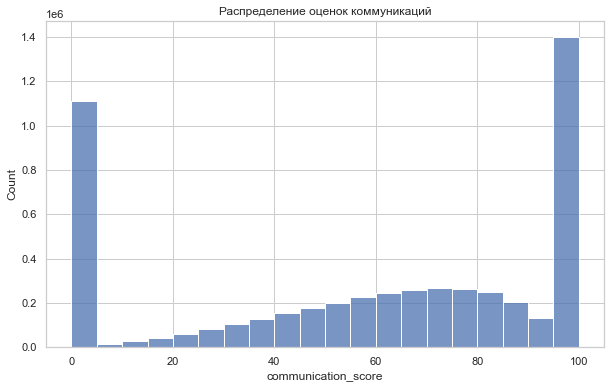

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data=communications, x='communication_score', bins=20)
plt.title('Распределение оценок коммуникаций')
plt.show()

В оценках наблюдаются две моды в 0 и 100, что является минимальным и максимальным результатами. При этом данные величины не являются выбросами из-за их частоты встречаемости.

## Employees анализ

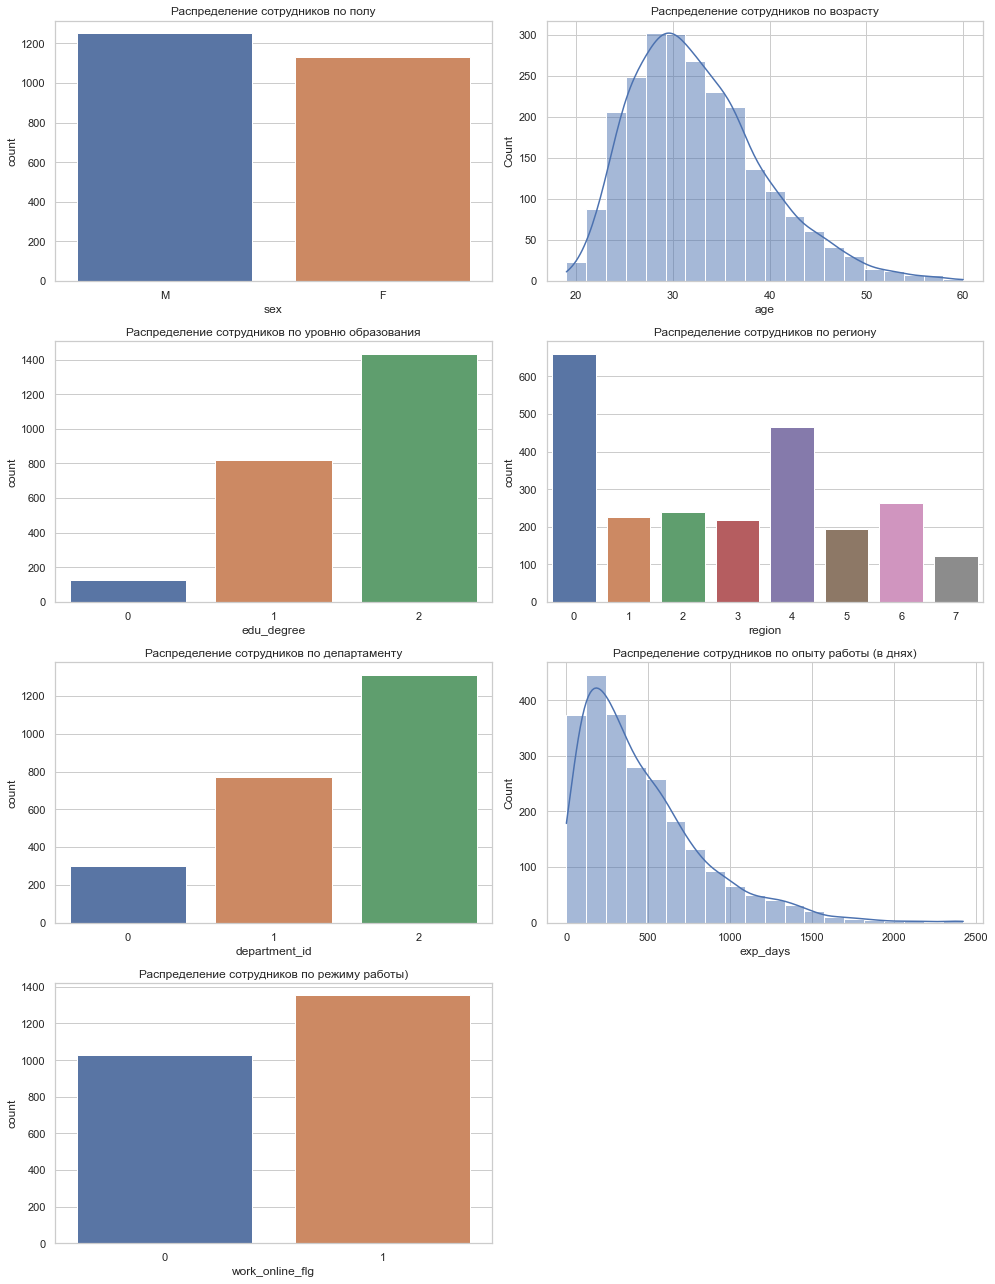

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18))

sns.countplot(x='sex', data=employees, ax=axes[0, 0])
axes[0, 0].set_title('Распределение сотрудников по полу')

sns.histplot(employees['age'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Распределение сотрудников по возрасту')

sns.countplot(x='edu_degree', data=employees, ax=axes[1, 0])
axes[1, 0].set_title('Распределение сотрудников по уровню образования')

sns.countplot(x='region', data=employees, ax=axes[1, 1])
axes[1, 1].set_title('Распределение сотрудников по региону')

sns.countplot(x='department_id', data=employees, ax=axes[2, 0])
axes[2, 0].set_title('Распределение сотрудников по департаменту')

sns.histplot(employees['exp_days'], bins=20, kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Распределение сотрудников по опыту работы (в днях)')

sns.countplot(x='work_online_flg', data=employees, ax=axes[3, 0])
axes[3, 0].set_title('Распределение сотрудников по режиму работы)')

fig.delaxes(axes[3, 1])
plt.tight_layout()
plt.show()

Из графиков видна несбалансированнасть в таких признаках как: департамент, уровень образования и частично в регионах. Распределение возраста и опыта работы сотрудников иммеет ассимитричный профиль.

## Анализ скоров

In [14]:
communications_employees = communications.merge(employees, on='employee_id')
avg_comm_scores = communications.groupby('employee_id').agg({'communication_score': 'mean', 'util_flg': 'mean'}).reset_index()
employee_data = pd.merge(employees, avg_comm_scores, on='employee_id', how='left')

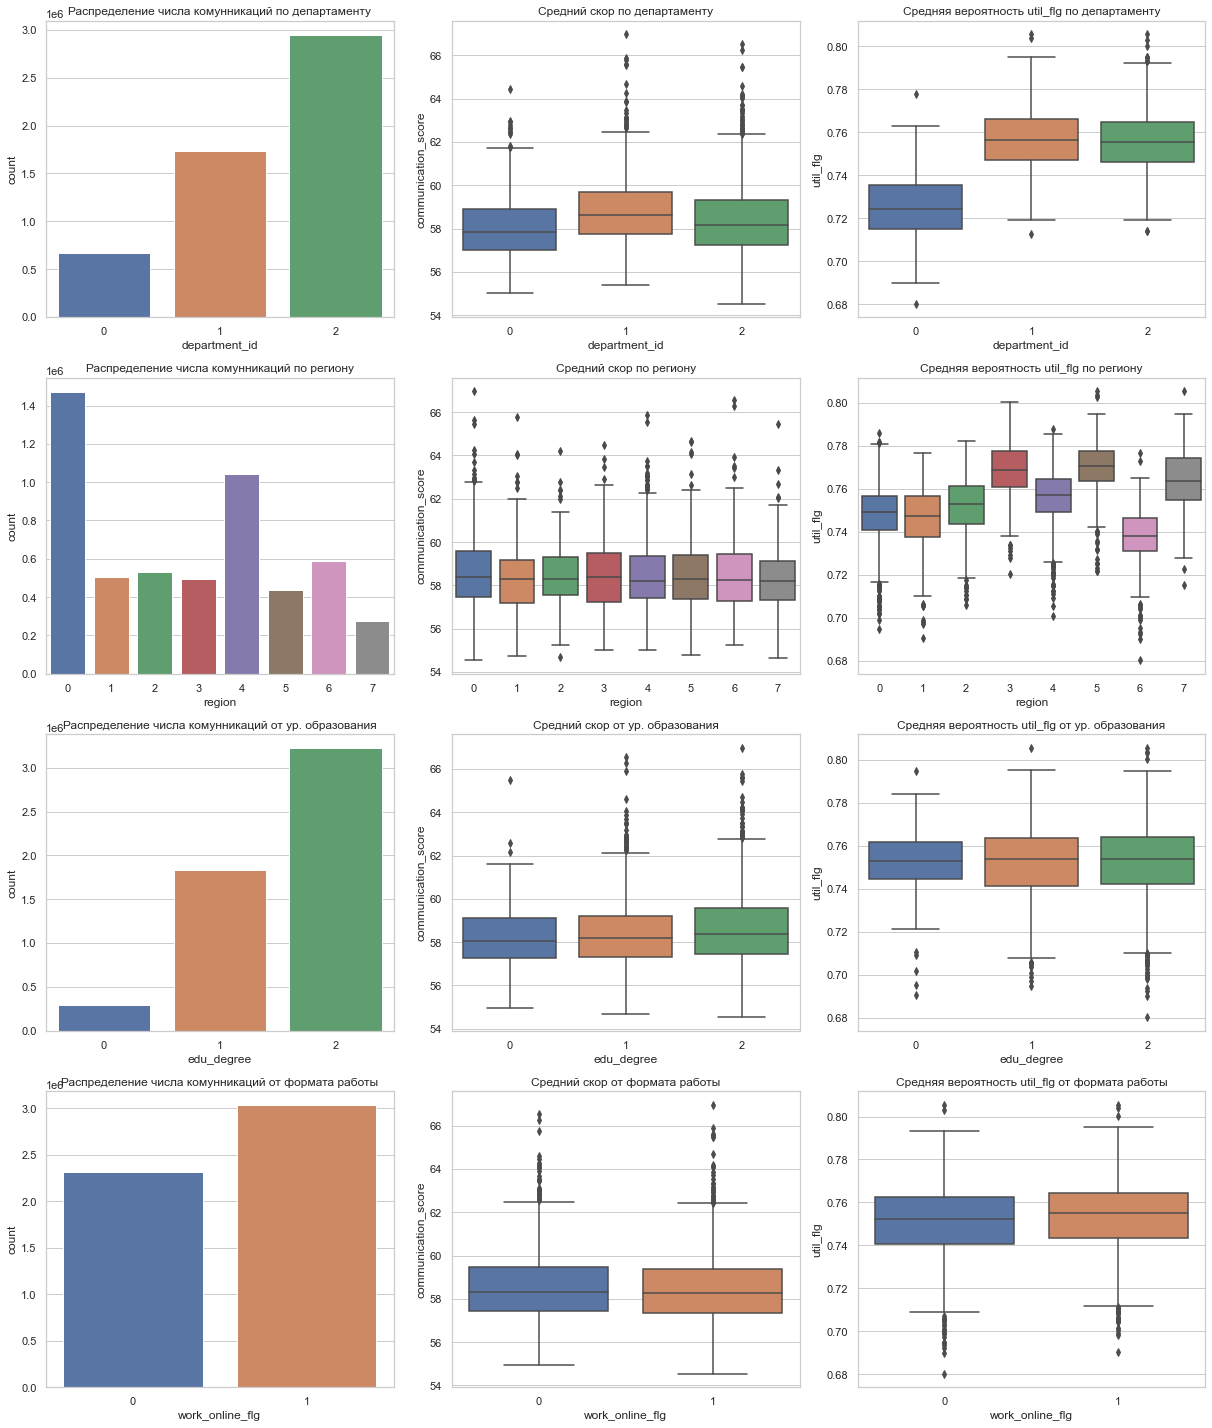

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(17, 20))

sns.countplot(data=communications_employees, x='department_id', ax=axes[0, 0])
axes[0, 0].set_title('Распределение числа комунникаций по департаменту')

sns.boxplot(data=employee_data, x='department_id', y='communication_score', ax=axes[0, 1])
axes[0, 1].set_title('Средний скор по департаменту')

sns.boxplot(data=employee_data, x='department_id', y='util_flg', ax=axes[0, 2])
axes[0, 2].set_title('Средняя вероятность util_flg по департаменту')

sns.countplot(data=communications_employees, x='region', ax=axes[1, 0])
axes[1, 0].set_title('Распределение числа комунникаций по региону')

sns.boxplot(data=employee_data, x='region', y='communication_score', ax=axes[1, 1])
axes[1, 1].set_title('Средний скор по региону')

sns.boxplot(data=employee_data, x='region', y='util_flg', ax=axes[1, 2])
axes[1, 2].set_title('Средняя вероятность util_flg по региону')

sns.countplot(data=communications_employees, x='edu_degree', ax=axes[2, 0])
axes[2, 0].set_title('Распределение числа комунникаций от ур. образования')

sns.boxplot(data=employee_data, x='edu_degree', y='communication_score', ax=axes[2, 1])
axes[2, 1].set_title('Средний скор от ур. образования')

sns.boxplot(data=employee_data, x='edu_degree', y='util_flg', ax=axes[2, 2])
axes[2, 2].set_title('Средняя вероятность util_flg от ур. образования')

sns.countplot(data=communications_employees, x='work_online_flg', ax=axes[3, 0])
axes[3, 0].set_title('Распределение числа комунникаций от формата работы')

sns.boxplot(data=employee_data, x='work_online_flg', y='communication_score', ax=axes[3, 1])
axes[3, 1].set_title('Средний скор от формата работы')

sns.boxplot(data=employee_data, x='work_online_flg', y='util_flg', ax=axes[3, 2])
axes[3, 2].set_title('Средняя вероятность util_flg от формата работы')

plt.tight_layout()
plt.show()

Как видно, ни каких корреляций между категориальными признаками не наблюдается в комбинации с оценками звонков и результатом взаимодейстия клиентов с продуктом. Присутсвует несбалансированнасть звонков в департаментах, регионах и при разном уровне образования, вследствие разного количества сотрудников в данных срезах.

## Распределение курсов

In [16]:
print('Минимальное число прохождений курса:', courses_passing.groupby('course_id')['employee_id'].count().min())
print('Максимальное число прохождений курса:', courses_passing.groupby('course_id')['employee_id'].count().max())

Минимальное число прохождений курса: 18
Максимальное число прохождений курса: 523


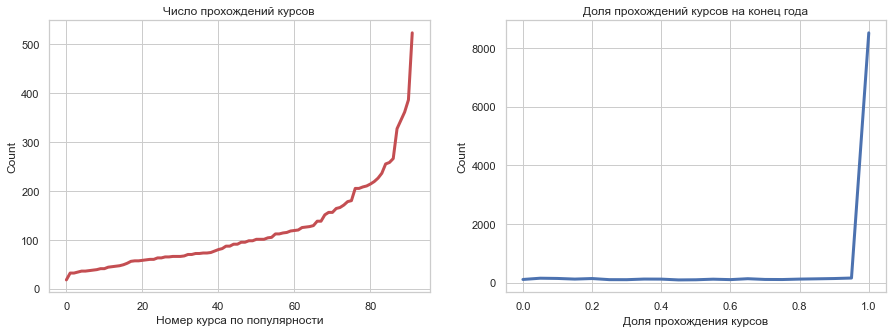

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(list(courses_passing.groupby('course_id')['employee_id'].count().sort_values()), 'r', lw=3)
axes[0].set_xlabel('Номер курса по популярности')
axes[0].set_ylabel('Count')
axes[0].set_title('Число прохождений курсов')

axes[1].plot(courses_passing.groupby('pass_frac')['employee_id'].count(), lw=3)
axes[1].set_xlabel('Доля прохождения курсов')
axes[1].set_ylabel('Count')
axes[1].set_title('Доля прохождений курсов на конец года')
plt.show()

In [18]:
print(sum(courses_passing['pass_frac'] == 1) / courses_passing.shape[0])
print(sum(courses_passing['pass_frac'] >= 0.8) / courses_passing.shape[0])

0.7774429223744292
0.8278538812785388


Наблюдается сильный разброс в количестве прохождений курсов, при этом видно, что 78% взаимодействий с курсом закончились его прохождением.

In [19]:
threshold_frac = 0.8 #минимальная доля пройденности курса
gamma = 14 #окно усреднения временного ряда
date_split = datetime.datetime(2023, 8, 1) #дата отсечки для теста и трейна

In [20]:
filtered_courses_passing = courses_passing[courses_passing['pass_frac'] >= threshold_frac].reset_index()
filtered_courses_passing = filtered_courses_passing[['course_id', 'employee_id', 'start_dt', 'last_activity_dt']]
filtered_courses_passing.head(5)

,course_id,employee_id,start_dt,last_activity_dt
0,24,53ed35c7-4a2e-c275-b837-374f04396c03,2023-01-30,2023-02-05
1,83,202cb962-ac59-075b-964b-07152d234b70,2023-08-29,2023-09-10
2,4,05f971b5-ec19-6b8c-65b7-5d2ef8267331,2023-07-29,2023-08-09
3,79,f4a331b7-a22d-1b23-7565-d8813a34d8ac,2023-05-30,2023-06-09
4,6,aba3b6fd-5d18-6d28-e06f-f97135cade7f,2023-07-12,2023-07-22


In [21]:
filtered_courses_passing.groupby('employee_id')['course_id'].count().describe()

count    1708.000000
mean        5.307377
std         4.262590
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        26.000000
Name: course_id, dtype: float64

In [22]:
filtered_courses_passing.groupby('course_id')['employee_id'].count().describe()

count     92.000000
mean      98.532609
std       77.448381
min       15.000000
25%       47.750000
50%       64.500000
75%      120.000000
max      389.000000
Name: employee_id, dtype: float64

In [23]:
%%time
employees_dict, progresses_communication_score, dates = built_time_series(communications, 'communication_score')

CPU times: total: 25.1 s
Wall time: 25.5 s


In [24]:
# %%time
# utils_communication_score = built_time_series(communications, 'util_flg', flag=False)

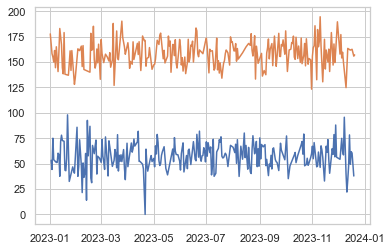

In [25]:
i, j = 790, 1350
plt.plot(dates[i], progresses_communication_score[i])
plt.plot(dates[j], np.array(progresses_communication_score[j])+100)
plt.show()

## Cоздание датафрейма c приростами от курсов

In [26]:
%%time
df_rating0 =  biult_frame_of_employees_course_data(filtered_courses_passing, progresses_communication_score, dates, employees_dict, gamma)
df_rating0.head()

CPU times: total: 25.1 s
Wall time: 25.6 s


,course_id,employee_id,start_dt,last_activity_dt,rating
0,24,53ed35c7-4a2e-c275-b837-374f04396c03,2023-01-30,2023-02-05,4.183246
1,83,202cb962-ac59-075b-964b-07152d234b70,2023-08-29,2023-09-10,-11.049706
2,4,05f971b5-ec19-6b8c-65b7-5d2ef8267331,2023-07-29,2023-08-09,-5.667455
3,79,f4a331b7-a22d-1b23-7565-d8813a34d8ac,2023-05-30,2023-06-09,4.643068
4,6,aba3b6fd-5d18-6d28-e06f-f97135cade7f,2023-07-12,2023-07-22,-6.733276


In [27]:
numeric_features = ['age', 'exp_days']
employees['sex'] = employees['sex'].apply(lambda x: 1 if (x == 'M' or x == 1) else 0)
categorical_features = ['edu_degree', 'department_id', 'region', 'sex', 'work_online_flg']

cols = ['employee_id'] + numeric_features + categorical_features
employees_features_ctb = employees[cols]
employees_features_ctb['employees_ind'] = employees_features_ctb['employee_id'].apply(lambda x: employees_dict[x])
employees_features_ctb = employees_features_ctb.sort_values('employees_ind').set_index('employees_ind', drop=True)
employees_features_ctb.head(3)

,employee_id,age,exp_days,edu_degree,department_id,region,sex,work_online_flg
employees_ind,,,,,,,,
0,0004d0b5-9e19-461f-f126-e3a08a814c33,28,140,2,2,0,1,0
1,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,29,378,1,1,3,0,1
2,006f52e9-102a-8d3b-e2fe-5614f42ba989,24,452,2,2,0,0,1


In [28]:
df_rating_ctb = df_rating0.copy()
df_rating_ctb = df_rating_ctb.drop(columns='start_dt')
df_rating_ctb = df_rating_ctb.merge(employees_features_ctb, on='employee_id')
df_rating_ctb['exp_days'] = df_rating_ctb[['exp_days', 'last_activity_dt']].apply(lambda row: row['exp_days'] + (row['last_activity_dt'] - datetime.datetime(2023,1,1)).days, axis=1)

df_rating_ctb = df_rating_ctb[cols + ['course_id', 'rating', 'last_activity_dt']]
df_rating_ctb.head()

,employee_id,age,exp_days,edu_degree,department_id,region,sex,work_online_flg,course_id,rating,last_activity_dt
0,53ed35c7-4a2e-c275-b837-374f04396c03,33,390,2,0,4,1,1,24,4.183246,2023-02-05
1,53ed35c7-4a2e-c275-b837-374f04396c03,33,513,2,0,4,1,1,9,0.103355,2023-06-08
2,53ed35c7-4a2e-c275-b837-374f04396c03,33,532,2,0,4,1,1,18,-4.150324,2023-06-27
3,53ed35c7-4a2e-c275-b837-374f04396c03,33,486,2,0,4,1,1,89,7.197805,2023-05-12
4,53ed35c7-4a2e-c275-b837-374f04396c03,33,453,2,0,4,1,1,40,6.181711,2023-04-09


## Распределение приростов по категориальным признакам

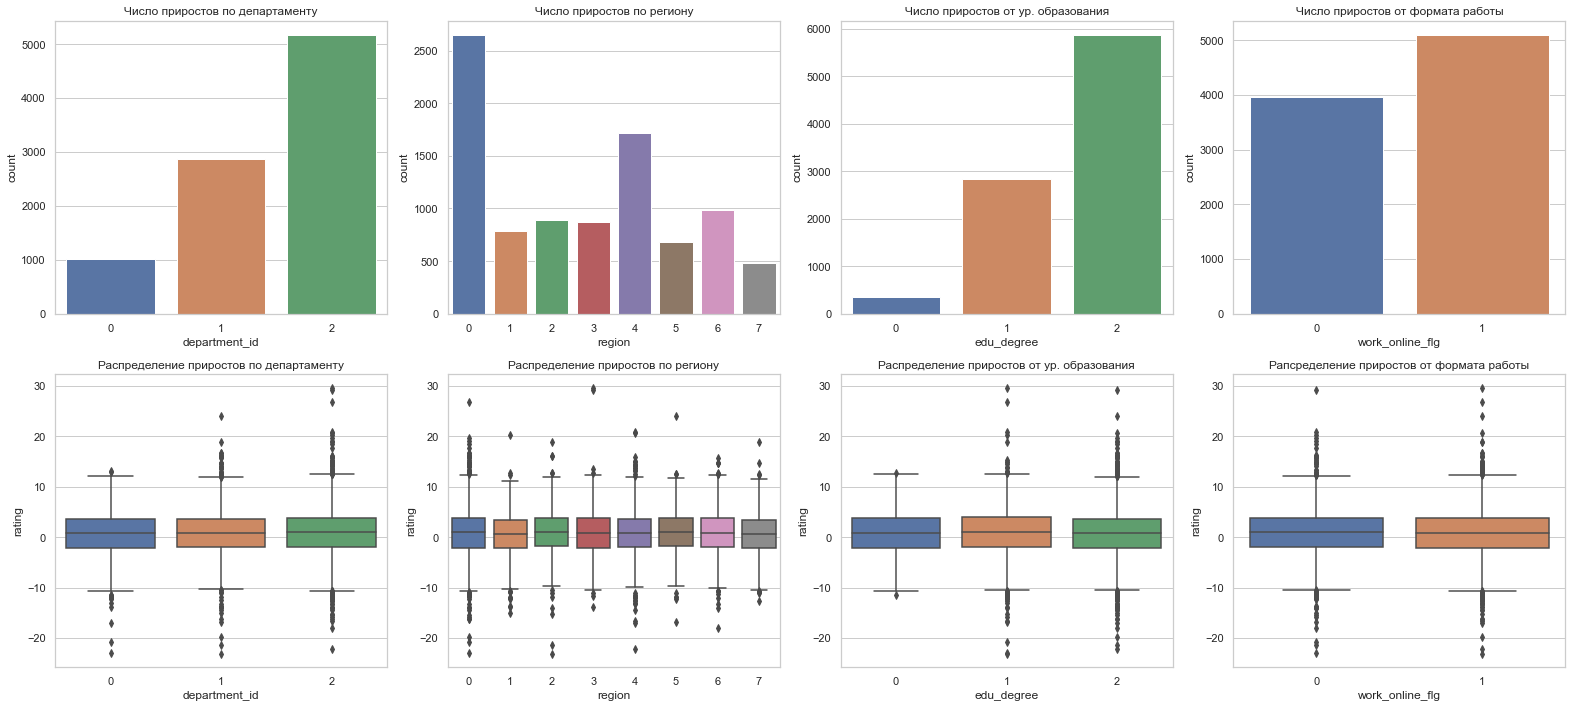

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

sns.countplot(data=df_rating_ctb, x='department_id', ax=axes[0, 0])
axes[0, 0].set_title('Число приростов по департаменту')

sns.boxplot(data=df_rating_ctb, x='department_id', y='rating', ax=axes[1, 0])
axes[1, 0].set_title('Распределение приростов по департаменту')


sns.countplot(data=df_rating_ctb, x='region', ax=axes[0, 1])
axes[0, 1].set_title('Число приростов по региону')

sns.boxplot(data=df_rating_ctb, x='region', y='rating', ax=axes[1, 1])
axes[1, 1].set_title('Распределение приростов по региону')


sns.countplot(data=df_rating_ctb, x='edu_degree', ax=axes[0, 2])
axes[0, 2].set_title('Число приростов от ур. образования')

sns.boxplot(data=df_rating_ctb, x='edu_degree', y='rating', ax=axes[1, 2])
axes[1, 2].set_title('Распределение приростов от ур. образования')

sns.countplot(data=df_rating_ctb, x='work_online_flg', ax=axes[0, 3])
axes[0, 3].set_title('Число приростов от формата работы')

sns.boxplot(data=df_rating_ctb, x='work_online_flg', y='rating', ax=axes[1, 3])
axes[1, 3].set_title('Рапсределение приростов от формата работы')


plt.tight_layout()
plt.show()

Из предложенных графиков видно, что корреляций между приростом от прохождения курсов и фичами сотрудника нету.

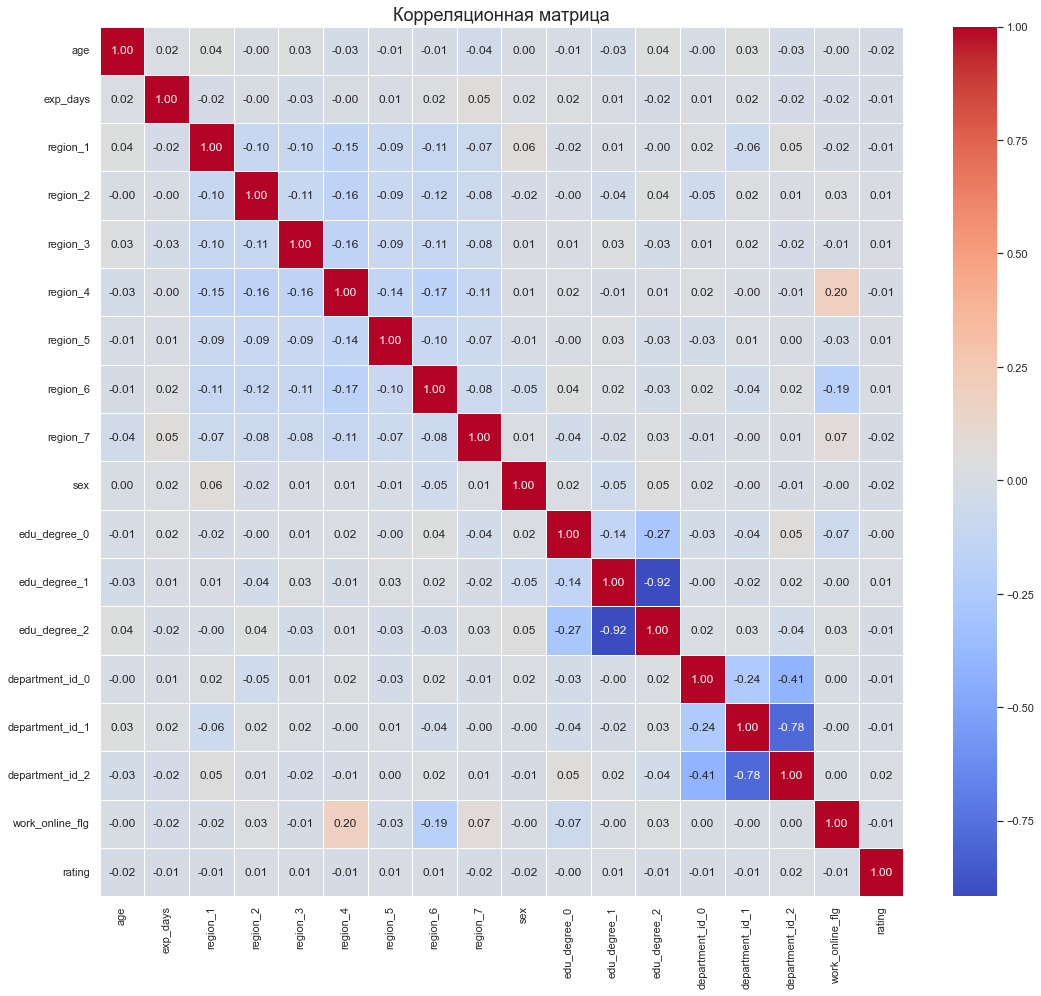

In [30]:
df_rating_ctb_OHE = pd.get_dummies(df_rating_ctb, columns=['edu_degree', 'region', 'department_id'])
correlation_matrix = df_rating_ctb_OHE[['age', 'exp_days', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7','sex', 'edu_degree_0', 'edu_degree_1', 'edu_degree_2',  'department_id_0', 'department_id_1', 'department_id_2', 'work_online_flg', 'rating']].corr()
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Корреляционная матрица', fontsize=18)
plt.show()

КОРРЕЛЯЦИЙ НЕ НАБЛЮДАЕТСЯ ВООБЩЕ (более сложная структурная зависимость может существовать).

# Выводы

Проведен EDA, который показал общие распределения и сведения о предложенных данных.
Итогом сталао наблюдение отсутствий корреляций в данных. Для решения данной проблемы требуется более сложный анализ с помощью ML.

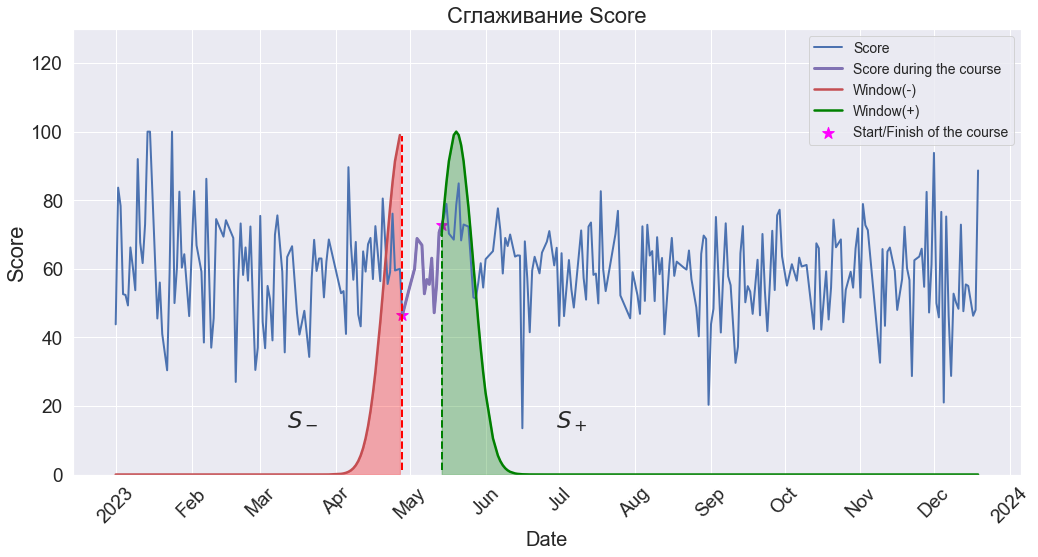

In [31]:
sns.set()
import matplotlib.dates as mdates
i = 15

days_start = np.array(dates[i][:94])
days_end = np.array(dates[i][106:])

days_st = np.array([(j - dates[i][94]).days for j in days_start])
days_en = np.array([(dates[i][105] - j).days for j in days_end])

plt.figure(figsize=(17, 8.2))
plt.plot(dates[i], progresses_communication_score[i], lw=2, label='Score')
plt.plot(dates[i][94:107], progresses_communication_score[i][94:107], 'm', lw=3, label='Score during the course')
plt.plot(days_start, 100*np.exp(-((days_st)/ 10) ** 2), 'r', lw=2.5, label='Window(-)')
plt.plot(days_end, 100*np.exp(-((days_en + 7)/ 10) ** 2), 'green', lw=2.5, label='Window(+)')
plt.axvline(x=dates[i][94], ymin=0.01, ymax=0.76, lw=2, color='red', linestyle='--')
plt.axvline(x=dates[i][106], ymin=0.01, ymax=0.54, lw=2, color='green', linestyle='--')

plt.scatter([dates[i][94], dates[i][106]], [progresses_communication_score[i][94], progresses_communication_score[i][106]], s=150, marker='*', color='magenta', label='Start/Finish of the course')
# plt.plot(dates[i][94:107], np.zeros(13), 'r', lw=4)
plt.ylabel('Score', fontsize=22)
plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(plt.gca().xaxis.get_major_locator())) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.gca().xaxis.set_tick_params(rotation = 45)
plt.title('Сглаживание Score', fontsize=22)
plt.legend(loc='upper right', fontsize=14)
# plt.grid()
plt.fill_between(days_end, 100*np.exp(-((days_en + 7)/ 10) ** 2), color='green', alpha=0.3)
plt.fill_between(days_start, 100*np.exp(-((days_st)/ 10) ** 2), color='red', alpha=0.3)
plt.figtext(0.3, 0.21, "$S_-$", fontsize=23)
plt.figtext(0.52, 0.205, "$S_+$", fontsize=23)
plt.ylim(0, 130)
plt.savefig('time_series.jpg')
plt.show()